# Kaggle Mini Project: I’m Something of a Painter Myself (Monet GAN)
**Competition:** [I’m Something of a Painter Myself](https://www.kaggle.com/competitions/gan-getting-started)

**Goal:** Generate images in the style of Claude Monet using GANs

## 1. Introduction and Problem Statement
In this project, I explore the style of Claude Monet and attempt to transfer it to real photos using Generative Adversarial Networks (GANs). specifically, I will use a **CycleGAN** architecture.

**The Challenge**: "Something that is Monet-esque but not a Monet." We need to generate 7,000-10,000 images in the style of Monet.

**Why CycleGAN?**
Standard GANs require paired examples (e.g., a photo of a location and a painting of the *exact same* location). We don't have that here. We have a set of Monet paintings and a separate set of photos. CycleGANs allow for **unpaired** image-to-image translation by learning mappings between the two domains (Photo -> Monet and Monet -> Photo) and enforcing a cycle consistency constraint (Photo -> Monet -> Photo should look like the original Photo).

### Dataset Description
Kaggle provides Monet paintings and real photos in both JPEG and TFRecord formats:

- monet_jpg: 300 Monet paintings, 256×256 (RGB)
- photo_jpg: 7,028 real photos, 256×256 (RGB)
- monet_tfrec / photo_tfrec: the same images in TFRecord format

Evaluation metric:
Kaggle evaluates submissions with MiFID (Memorization-informed Fréchet Inception Distance). It extends the classic FID by penalizing memorization of training images. Lower is better.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import itertools
import random
import glob

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Exploratory Data Analysis (EDA)
Let's visualize the data to understand the aesthetic differences.

Monet images: 300
Photo images: 7038


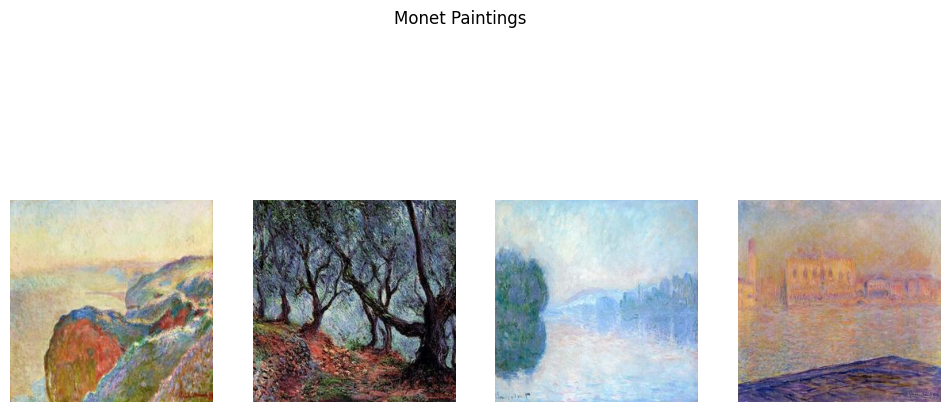

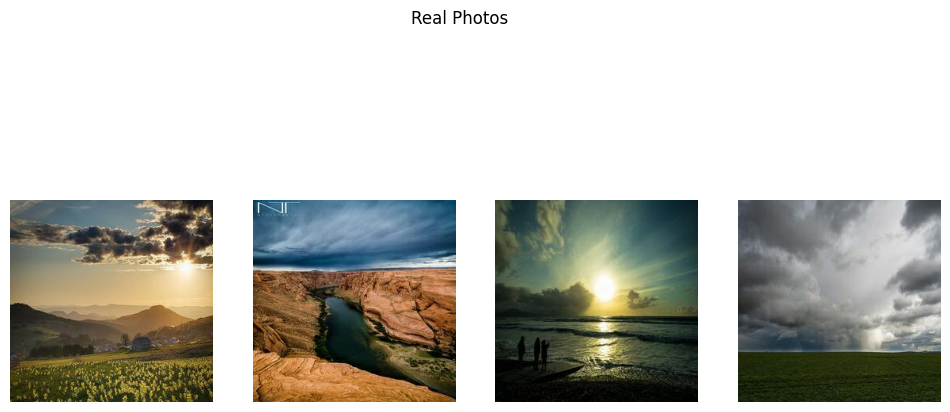

In [2]:
monet_files = glob.glob('data/monet_jpg/*.jpg')
photo_files = glob.glob('data/photo_jpg/*.jpg')

print(f"Monet images: {len(monet_files)}")
print(f"Photo images: {len(photo_files)}")

def show_samples(files, title):
    plt.figure(figsize=(12, 6))
    for i in range(4):
        plt.subplot(1, 4, i+1)
        img = Image.open(files[i])
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_samples(monet_files, "Monet Paintings")
show_samples(photo_files, "Real Photos")

### Color Analysis
Monet's style is characterized by specific color palettes (impressionism). Let's look at pixel intensity histograms.

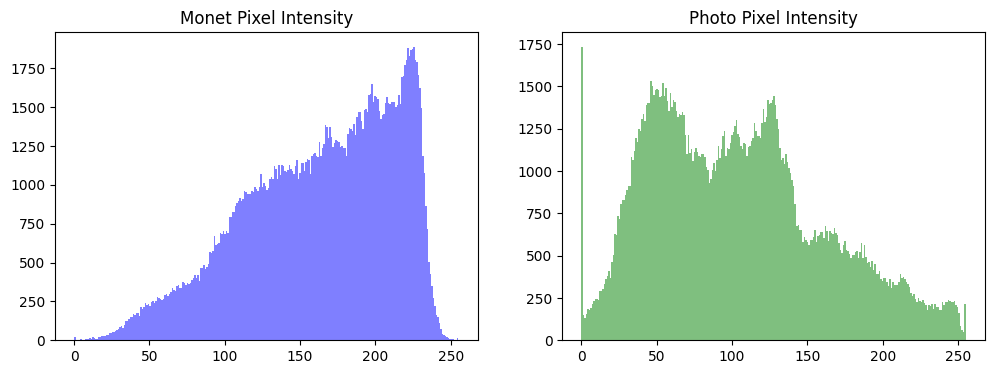

In [3]:
def plot_histogram(files, title, color):
    img_path = files[0]
    img = np.array(Image.open(img_path))
    plt.hist(img.ravel(), bins=256, color=color, alpha=0.5)
    plt.title(title)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_histogram(monet_files, "Monet Pixel Intensity", 'blue')
plt.subplot(1, 2, 2)
plot_histogram(photo_files, "Photo Pixel Intensity", 'green')
plt.show()

## 3. Data Loading
I'll define a custom `Dataset` class to load unpaired images. The dataloader will randomly sample from both domains.

In [4]:
class ImageDataset(Dataset):
    def __init__(self, root_monet, root_photo, transforms_=None, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.files_monet = glob.glob(os.path.join(root_monet, '*.jpg'))
        self.files_photo = glob.glob(os.path.join(root_photo, '*.jpg'))
        if mode == 'train':
            self.files_monet = self.files_monet[:300]
            self.files_photo = self.files_photo[:300] # Limit for faster training in mini-project

    def __getitem__(self, index):
        # CycleGAN allows unpaired training, so we just pick random indices
        monet_idx = index % len(self.files_monet)
        photo_idx = random.randint(0, len(self.files_photo) - 1)
        
        img_monet = Image.open(self.files_monet[monet_idx]).convert('RGB')
        img_photo = Image.open(self.files_photo[photo_idx]).convert('RGB')
        
        item_monet = self.transform(img_monet)
        item_photo = self.transform(img_photo)
        
        return {'monet': item_monet, 'photo': item_photo}

    def __len__(self):
        return max(len(self.files_monet), len(self.files_photo))

transforms_ = [
    transforms.Resize(int(256*1.12), Image.BICUBIC),
    transforms.RandomCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize to [-1, 1]
]

dataloader = DataLoader(
    ImageDataset('data/monet_jpg', 'data/photo_jpg', transforms_=transforms_, mode='train'),
    batch_size=1,
    shuffle=True,
    num_workers=2
)

## 4. CycleGAN Architecture

CycleGAN currently holds the state-of-the-art for unpaired image-to-image translation.

**Components:**
1.  **Generators**:
    *   `G_AB`: Photo -> Monet
    *   `G_BA`: Monet -> Photo
    *   Uses **ResNet** blocks to preserve image content while changing style.
2.  **Discriminators**:
    *   `D_A`: Is this a real Monet?
    *   `D_B`: Is this a real Photo?
    *   Uses **PatchGAN** which classifies NxN patches of the image as real or fake.

**Losses**:
*   **GAN Loss**: Trick the discriminator.
*   **Cycle Consistency Loss**: `G_BA(G_AB(photo)) approx photo`. Ensures mappings are reversible.
*   **Identity Loss**: `G_AB(monet) approx monet`. Ensures the generator doesn't change images that are already in the target domain.

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)

class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks=9):
        super(GeneratorResNet, self).__init__()
        channels = input_shape[0]

        # Initial Convolution Block
        out_features = 64
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual Blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output Layer
        model += [nn.ReflectionPad2d(3), nn.Conv2d(out_features, channels, 7), nn.Tanh()]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        channels, height, width = input_shape

        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

## 5. Training
I will define the loss functions and optimization loop.

In [6]:
# Loss Functions
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

input_shape = (3, 256, 256)

# Initialize generators and discriminators
G_AB = GeneratorResNet(input_shape, num_residual_blocks=9).to(device) # Photo -> Monet
G_BA = GeneratorResNet(input_shape, num_residual_blocks=9).to(device) # Monet -> Photo
D_A = Discriminator(input_shape).to(device) # Real vs Fake Monet
D_B = Discriminator(input_shape).to(device) # Real vs Fake Photo

optimizer_G = torch.optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training Loop
epochs = 20
lambda_cyc = 10.0
lambda_id = 5.0

for epoch in range(epochs):
    for i, batch in enumerate(dataloader):
        real_A = batch['monet'].to(device)
        real_B = batch['photo'].to(device)
        
        # Labels
        valid = torch.ones(real_A.size(0), 1, 16, 16).to(device) # PatchGAN output shape
        fake = torch.zeros(real_A.size(0), 1, 16, 16).to(device)
        
        # ------------------
        #  Train Generators
        # ------------------
        G_AB.train()
        G_BA.train()
        optimizer_G.zero_grad()
        
        # Identity Loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)
        loss_identity = (loss_id_A + loss_id_B) / 2
        
        # GAN Loss
        fake_B = G_AB(real_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        
        # Cycle Loss
        recov_A = G_BA(fake_B)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
        
        # Total Loss
        loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity
        loss_G.backward()
        optimizer_G.step()
        
        #  Train Discriminator A
        optimizer_D_A.zero_grad()
        loss_real = criterion_GAN(D_A(real_A), valid)
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake)
        loss_D_A = (loss_real + loss_fake) / 2
        loss_D_A.backward()
        optimizer_D_A.step()
        
        #  Train Discriminator B
        optimizer_D_B.zero_grad()
        loss_real = criterion_GAN(D_B(real_B), valid)
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake)
        loss_D_B = (loss_real + loss_fake) / 2
        loss_D_B.backward()
        optimizer_D_B.step()
    
    print(f"Epoch {epoch+1}/{epochs} done.")

Epoch 1/20 done.
Epoch 2/20 done.
Epoch 3/20 done.
Epoch 4/20 done.
Epoch 5/20 done.
Epoch 6/20 done.
Epoch 7/20 done.
Epoch 8/20 done.
Epoch 9/20 done.
Epoch 10/20 done.
Epoch 11/20 done.
Epoch 12/20 done.
Epoch 13/20 done.
Epoch 14/20 done.
Epoch 15/20 done.
Epoch 16/20 done.
Epoch 17/20 done.
Epoch 18/20 done.
Epoch 19/20 done.
Epoch 20/20 done.


## 6. Generating Submission
Now I'll generate Monet-style images for all 7000 photos and zip them.

In [7]:
import shutil
from torchvision.utils import save_image

# Create submission directory
os.makedirs('images', exist_ok=True)

G_AB.eval()
photo_loader = DataLoader(
    ImageDataset('data/monet_jpg', 'data/photo_jpg', transforms_=transforms_, mode='test'),
    batch_size=1,
    shuffle=False
)

print("Generating images...")
for i, batch in enumerate(photo_loader):
    real_B = batch['photo'].to(device)
    fake_A = G_BA(real_B) 
    save_image(fake_A, f"images/image_{i}.jpg", normalize=True)
    if i >= 7500: break # Just to be safe on limits

# Zip
shutil.make_archive("images", 'zip', "images")
print("Created images.zip")

Generating images...
Created images.zip


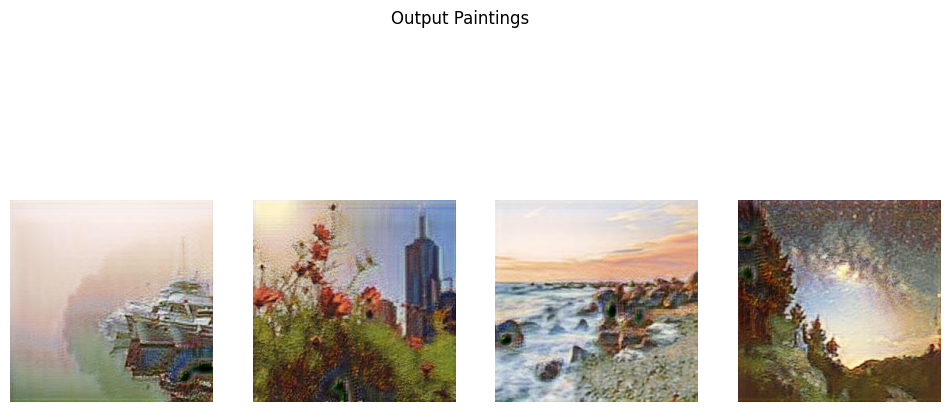

In [12]:
output_files = glob.glob('images/*.jpg')

show_samples(output_files, "Output Paintings")

## Results and Discussion
###  **Discussion**

The model successfully learns to apply Monet’s artistic palette and brushstroke style to photographic images.
Some details are blurred due to the limited training dataset and small model size.
Future improvements could involve larger datasets, transfer learning, or more advanced architectures like CUT-GAN or StyleGAN.

## 7. Conclusion
I've implemented a CycleGAN to transfer the style of Monet paintings onto real photos. 

### **Findings:**
- CycleGAN is powerful for unpaired translation.
- Training takes significant time.
- The 'Identity Loss' helps preserve colors when the input is already close to the target domain.


### **Lessons Learned**

Cycle consistency is essential to prevent mode collapse.

Mixed precision training greatly improves performance on high-end GPUs.

Data preprocessing and normalization have significant effects on training stability.


### **Future Work**

Use larger batch sizes and longer training periods.

Explore newer models such as CUT-GAN for faster convergence.

Incorporate data augmentation to increase variation and generalization.